In [2]:
import Pkg
Pkg.activate("packages")
Pkg.instantiate()
using CSV, DataFrames, Plots, Plots.PlotMeasures, StatsPlots, Statistics

  Activating environment at `~/Documents/Still evolving/Quantifying-SIM/packages/Project.toml`
Precompiling project...
  ✓ PrecompileTools
  ✓ Wayland_protocols_jll
  ✓ Xorg_libpthread_stubs_jll
  ✓ Xorg_xtrans_jll
  ✓ IntelOpenMP_jll
  ✓ Xorg_libXdmcp_jll
  ✓ Xorg_libXau_jll
  ✓ Rmath_jll
  ✓ Wayland_jll
  ✓ ZMQ
  ✓ Xorg_libxcb_jll
  ✓ MKL_jll
  ✓ Rmath
  ✓ RecipesBase
  ✓ Xorg_xcb_util_jll
  ✓ Xorg_libX11_jll
  ✓ OpenSSL
  ✓ Xorg_xcb_util_image_jll
  ✓ Xorg_libXext_jll
  ✓ Xorg_xcb_util_renderutil_jll
  ✓ Xorg_xcb_util_keysyms_jll
  ✓ Xorg_xcb_util_wm_jll
  ✓ Xorg_libXrender_jll
  ✓ Xorg_libxkbfile_jll
  ✓ Xorg_libXfixes_jll
  ✓ Xorg_libXinerama_jll
  ✓ Libglvnd_jll
  ✓ Xorg_libXrandr_jll
  ✓ Xorg_xkbcomp_jll
  ✓ Xorg_libXcursor_jll
  ✓ Xorg_libXi_jll
  ✓ SpecialFunctions
  ✓ FFTW
  ✓ Xorg_xkeyboard_config_jll
  ✓ DiffRules
  ✓ xkbcommon_jll
  ✓ GLFW_jll
  ✓ DualNumbers
  ✓ HTTP
  ✓ HypergeometricFunctions
  ✓ ColorVectorSpace
  ✓ StatsFuns
  ✓ Qt5Base_jll
  ✓ ForwardDiff
  ✓ Cairo_j

### Figure 2: Quantification of the accuray and precision of our inference method using simulated mutant count data

In [21]:
# Reading the (true) input parameters
p = "range_mu-inc"
p2 = "range_switching"
true_para_1 = DataFrame(CSV.File("input_parameters/"*p*".csv"))
true_para_2 = DataFrame(CSV.File("input_parameters/"*p2*".csv"))
range_para_1 = 10 .^ collect(true_para_1.r_start[1]:true_para_1.r_increment[1]:true_para_1.r_end[1]) / true_para_1.divisions_off[1]
range_para_2 = 10 .^ collect(true_para_2.r_start[1]:true_para_2.r_increment[1]:true_para_2.r_end[1]) / true_para_1.divisions_off[1]
J1 = length(range_para_1)
J2 = length(range_para_2)
mu_off_true = true_para_1.mutations_off[1] / true_para_1.divisions_off[1];

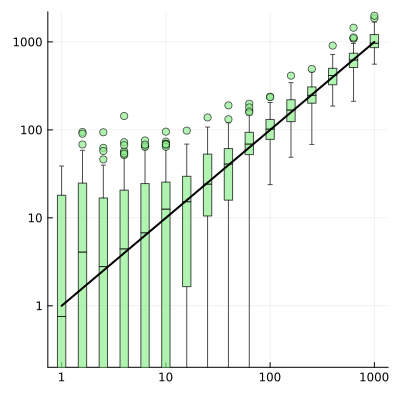

In [22]:
# Reading and plotting the inferred parameters
# Estimation method: heterogeneous-response model, rel. division rate set to zero, known f_on
# Estimated compared to true mutation-rate increase for switching=0.01
m = "het_zero_div"
P_inc = plot(size=(400,400))
r = 11
for j1 = 1:2:J1
    inferred_para = subset(DataFrame(CSV.File("inferred_parameters/"*p*"/switch_$r/"*m*"_$j1.csv")), :AIC => ByRow(a->!isinf(a)))
    boxplot!(P_inc, [j1], inferred_para.mutation_rate_on ./ inferred_para.mutation_rate_off, lab="", c=:lightgreen, alpha=0.7)
end
plot!(P_inc, xticks=(collect(1:10:J1), Int.(range_para_1[1:10:J1])), yticks=(Int.(range_para_1[1:10:J1]), Int.(range_para_1[1:10:J1])), yscale=:log10, ylim=(0.2, 2200))
plot!(range_para_1, c=:black, width=2, lab="")
#plot!(ylab="Estimated mutation-rate increase", xlab="True mutation-rate increase", title="Relative switching rate = $(round(range_para_2[r], digits=3))")

In [6]:
# Determining numerical values for the precision
i = 21
inferred_para = subset(DataFrame(CSV.File("inferred_parameters/"*p*"/switch_$r/"*m*"_$i.csv")), :AIC => ByRow(a->!isinf(a)))
println("True mutation-rate increase = ", range_para_1[i])
println("25 and 75 percent quantiles: ", quantile(inferred_para.mutation_rate_on ./ inferred_para.mutation_rate_off, [0.25,0.75])/ range_para_1[i])
println("")
i = 15
inferred_para = subset(DataFrame(CSV.File("inferred_parameters/"*p*"/switch_$r/"*m*"_$i.csv")), :AIC => ByRow(a->!isinf(a)))
println("True mutation-rate increase = ", range_para_1[i])
q2, q4 = quantile(inferred_para.mutation_rate_on ./ inferred_para.mutation_rate_off, [0.25, 0.75])
IQR = q4 - q2
println("Maximum estimated mutation-rate = ", maximum((inferred_para.mutation_rate_on ./ inferred_para.mutation_rate_off)[inferred_para.mutation_rate_on ./ inferred_para.mutation_rate_off .< q4 + 1.5*IQR]))

True mutation-rate increase = 100.0
25 and 75 percent quantiles: [0.7803450056982675, 1.3151145797549182]

True mutation-rate increase = 25.118864315095795
Maximum estimated mutation-rate = 107.75252281344603


In [7]:
# Reading and plotting the inferred parameters
# Estimation method: heterogeneous-response model, rel. division rate set to zero, known f_on
# Relative error and coefficient of variation across the estimates
m = "het_zero_div"
RE_alpha_mu = Matrix{Float64}(undef, (J2, J1))
CV_alpha_mu = Matrix{Float64}(undef, (J2, J1))
for j2 = 1:J2
    p_folder = "/switch_$j2"
    for j1 = 1:J1
        inferred_para = subset(DataFrame(CSV.File("inferred_parameters/"*p*p_folder*"/"*m*"_$j1.csv")), :AIC => ByRow(a->!isinf(a)))
        RE_alpha_mu[j2, j1] = (median(inferred_para.mutation_rate_on ./ inferred_para.mutation_rate_off) - range_para_1[j1]) / range_para_1[j1]
        CV_alpha_mu[j2, j1] = std(inferred_para.mutation_rate_on ./ inferred_para.mutation_rate_off) / mean(inferred_para.mutation_rate_on ./ inferred_para.mutation_rate_off)
    end
end

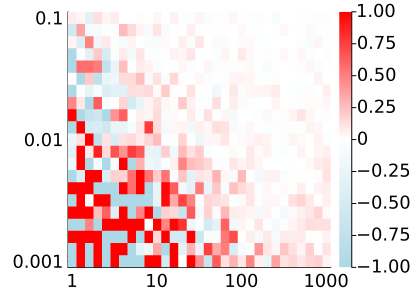

In [15]:
c_max = 1
c_min = -1
P_RE = plot(size=(420,300), rightmargin=10mm)
heatmap!(RE_alpha_mu, c=cgrad([:lightblue,:white,:red], [0,-c_min/(c_max-c_min),1]), clim=(c_min, c_max))
plot!(xticks=(collect(1:10:J1), Int.(range_para_1[1:10:J1])), yticks=(collect(1:10:J2), range_para_2[1:10:J2]), tickfontsize=12)
#plot!(title="Relative error (median)", xlab="Mutation-rate increase", ylab="Relative switching rate")

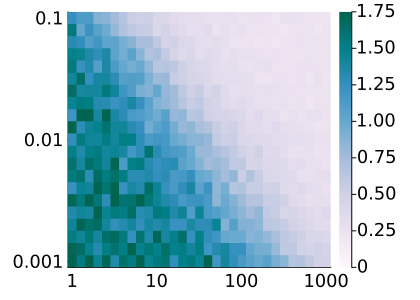

In [16]:
P_CV = plot(size=(420,300), rightmargin=10mm)
heatmap!(CV_alpha_mu, fill=true, levels=8, c=:PuBuGn_8, clim=(0, 1.75))
plot!(xticks=(collect(1:10:J1), Int.(range_para_1[1:10:J1])), yticks=(collect(1:10:J2), range_para_2[1:10:J2]), tickfontsize=12)
#plot!(title="Coefficient of variation", xlab="Mutation-rate increase", ylab="Relative switching rate")

In [23]:
savefig(P_inc, "figures/Figure_2A.pdf")
savefig(P_RE, "figures/Figure_2B.png")
savefig(P_CV, "figures/Figure_2C.png")

"/Users/lucylansch-justen/Documents/Still evolving/Quantifying-SIM/figures/Figure_2A.pdf"

### Figure 3: Impact of cell death on the estimation of the mutation-rate increase

In [24]:
# Reading the (true) input parameters
p = "range_death-off_switch-5"
p2 = "range_death-on_switch-5"
true_para = DataFrame(CSV.File("input_parameters/"*p*".csv"))
range_para = collect(true_para.r_start[1]:true_para.r_increment[1]:true_para.r_end[1]) / true_para.divisions_off[1]
J = length(range_para)
mu_off_true = true_para.mutations_off[1]
mu_on_true = true_para.mutations_on[1];

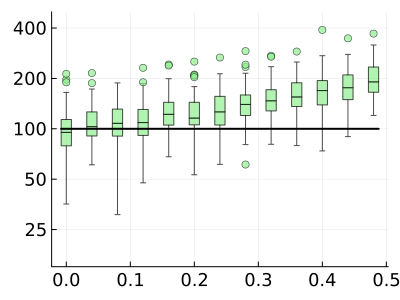

In [4]:
# Reading and plotting the inferred parameters
# Estimation method: heterogeneous-response model, rel. division rate set to zero, known f_on
# Only response-off cells are affected by cell death
m = "het_zero_div"
P_inc_off = plot(size=(400,300))
r = 1
for j = 1:2:J
    inferred_para = subset(DataFrame(CSV.File("inferred_parameters/"*p*"/death-on_$r/"*m*"_$j.csv")), :AIC => ByRow(a->!isinf(a)))
    boxplot!(P_inc_off, [j], inferred_para.mutation_rate_on ./ inferred_para.mutation_rate_off, lab="", c=:lightgreen, alpha=0.7)
end
plot!(P_inc_off, xticks=(collect(1:5:J), range_para[1:5:J]), yscale=:log10, yticks=([25,50,100,200,400], [25,50,100,200,400]), ylim=(15,500))
plot!(x->mu_on_true/mu_off_true, c=:black, width=2, lab="", tickfontsize=12)
#plot!(title="Only response-off cells affected", xlab="Extinction probability", ylab="Estimated mutation-rate increase")


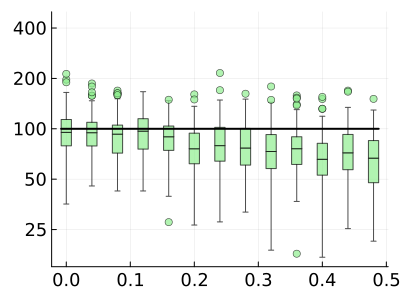

In [6]:
# Reading and plotting the inferred parameters
# Estimation method: heterogeneous-response model, rel. division rate set to zero, known f_on
# Only response-on cells are affected by cell death
m = "het_zero_div"
P_inc_on = plot(size=(400,300))
r = 1
for j = 1:2:J
    inferred_para = subset(DataFrame(CSV.File("inferred_parameters/"*p*"/death-on_$j/"*m*"_$r.csv")), :AIC => ByRow(a->!isinf(a)))
    boxplot!(P_inc_on, [j], inferred_para.mutation_rate_on ./ inferred_para.mutation_rate_off, lab="", c=:lightgreen, alpha=0.7)
end
plot!(P_inc_on, xticks=(collect(1:5:J), range_para[1:5:J]), yscale=:log10, yticks=([25,50,100,200,400], [25,50,100,200,400]), ylim=(15,500))
plot!(x->mu_on_true/mu_off_true, c=:black, width=2, lab="", tickfontsize=12)
#plot!(title="Only response-on cells affected", xlab="Extinction probability", ylab="Estimated mutation-rate increase")


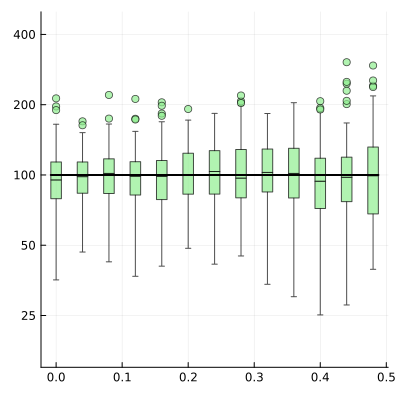

In [25]:
# Reading and plotting the inferred parameters
# Estimation method: heterogeneous-response model, rel. division rate set to zero, known f_on
# All cells are affected by cell death equally
m = "het_zero_div"
P_inc_all = plot(size=(400,400))
for j = 1:2:J
    inferred_para = subset(DataFrame(CSV.File("inferred_parameters/"*p*"/death-on_$j/"*m*"_$j.csv")), :AIC => ByRow(a->!isinf(a)))
    boxplot!(P_inc_all, [j], inferred_para.mutation_rate_on ./ inferred_para.mutation_rate_off, lab="", c=:lightgreen, alpha=0.7)
end
plot!(P_inc_all, xticks=(collect(1:5:J), range_para[1:5:J]), yscale=:log10, yticks=([25,50,100,200,400], [25,50,100,200,400]), ylim=(15,500))
plot!(x->mu_on_true/mu_off_true, c=:black, width=2, lab="")
#plot!(title="All cells affected equally", xlab="Extinction probability", ylab="Estimated mutation-rate increase")


In [27]:
savefig(P_inc_off, "figures/Figure_3A.pdf")
savefig(P_inc_on, "figures/Figure_3B.pdf")
savefig(P_inc_all, "figures/Figure_3C.pdf")

"/Users/lucylansch-justen/Documents/Still evolving/Quantifying-SIM/figures/Figure_3C.pdf"

#### Appendix Figure: Impact of cell death for different switching rates

In [28]:
# Reading the (true) input parameters
# Switching rate = 0.01 and 0.05
p_1 = "range_death-off_switch-1"
p2_1 = "range_death-on_switch-1"
p_5 = "range_death-off_switch-5"
p2_5 = "range_death-on_switch-5"
true_para = DataFrame(CSV.File("input_parameters/"*p*".csv"))
range_para = collect(true_para.r_start[1]:true_para.r_increment[1]:true_para.r_end[1]) / true_para.divisions_off[1]
J = length(range_para)
mu_off_true = true_para.mutations_off[1]
mu_on_true = true_para.mutations_on[1];

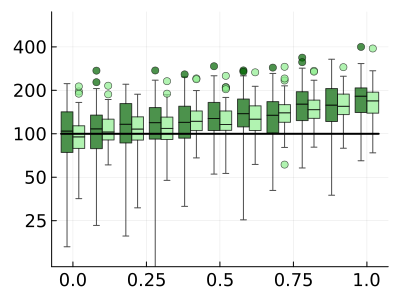

In [45]:
# Reading and plotting the inferred parameters
# Estimation method: heterogeneous-response model, rel. division rate set to zero, known f_on
# Only response-off cells are affected by cell death
m = "het_zero_div"
P_inc_off_A = plot(size=(400,300))
r = 1
for j = 1:2:J
    inferred_para_1 = subset(DataFrame(CSV.File("inferred_parameters/"*p_1*"/death-on_$r/"*m*"_$j.csv")), :AIC => ByRow(a->!isinf(a)))
    boxplot!(P_inc_off_A, [j-0.4], inferred_para_1.mutation_rate_on ./ inferred_para_1.mutation_rate_off, lab="", c=:darkgreen, alpha=0.7)
    inferred_para_5 = subset(DataFrame(CSV.File("inferred_parameters/"*p_5*"/death-on_$r/"*m*"_$j.csv")), :AIC => ByRow(a->!isinf(a)))
    boxplot!(P_inc_off_A, [j+0.4], inferred_para_5.mutation_rate_on ./ inferred_para_5.mutation_rate_off, lab="", c=:lightgreen, alpha=0.7)
end
plot!(P_inc_off_A, xticks=(collect(1:5:J), range_para[1:5:J]), yscale=:log10, yticks=([25,50,100,200,400], [25,50,100,200,400]), ylim=(12,700))
plot!(x->mu_on_true/mu_off_true, c=:black, width=2, lab="", tickfontsize=12)
#plot!(title="Only response-off cells affected", xlab="Extinction probability", ylab="Estimated mutation-rate increase", legend=:bottomright)
#scatter!([0], [1], lab="Switching rate = 0.01", c=:darkgreen, alpha=0.7, marker=:square)
#scatter!([0], [1], lab="Switching rate = 0.05", c=:lightgreen, alpha=0.7, marker=:square)

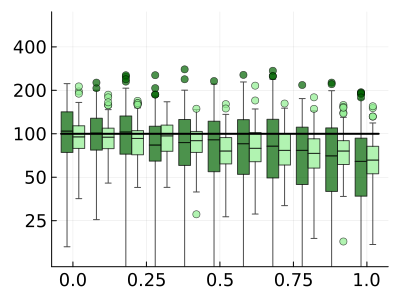

In [46]:
# Reading and plotting the inferred parameters
# Estimation method: heterogeneous-response model, rel. division rate set to zero, known f_on
# Only response-on cells are affected by cell death
m = "het_zero_div"
P_inc_on_A = plot(size=(400,300))
r = 1
for j = 1:2:J
    inferred_para_1 = subset(DataFrame(CSV.File("inferred_parameters/"*p_1*"/death-on_$j/"*m*"_$r.csv")), :AIC => ByRow(a->!isinf(a)))
    boxplot!(P_inc_on_A, [j-0.4], inferred_para_1.mutation_rate_on ./ inferred_para_1.mutation_rate_off, lab="", c=:darkgreen, alpha=0.7)
    inferred_para_5 = subset(DataFrame(CSV.File("inferred_parameters/"*p_5*"/death-on_$j/"*m*"_$r.csv")), :AIC => ByRow(a->!isinf(a)))
    boxplot!(P_inc_on_A, [j+0.4], inferred_para_5.mutation_rate_on ./ inferred_para_5.mutation_rate_off, lab="", c=:lightgreen, alpha=0.7)
end
plot!(P_inc_on_A, xticks=(collect(1:5:J), range_para[1:5:J]), yscale=:log10, yticks=([25,50,100,200,400], [25,50,100,200,400]), ylim=(12,700))
plot!(x->mu_on_true/mu_off_true, c=:black, width=2, lab="", tickfontsize=12)
#plot!(title="Only response-on cells affected", xlab="Extinction probability", ylab="Estimated mutation-rate increase", legend=:topleft)
#scatter!([0], [1], lab="Switching rate = 0.01", c=:darkgreen, alpha=0.7, marker=:square)
#scatter!([0], [1], lab="Switching rate = 0.05", c=:lightgreen, alpha=0.7, marker=:square)

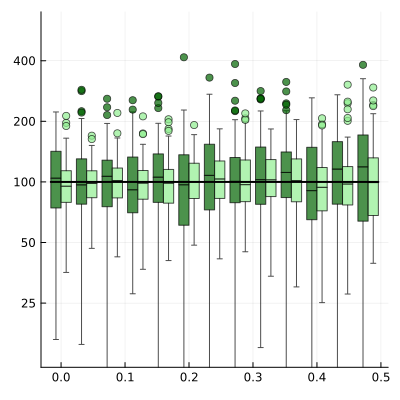

In [29]:
# Reading and plotting the inferred parameters
# Estimation method: heterogeneous-response model, rel. division rate set to zero, known f_on
# All cells are affected by cell death equally
m = "het_zero_div"
P_inc_all_A = plot(size=(400,400))
for j = 1:2:J
    inferred_para_1 = subset(DataFrame(CSV.File("inferred_parameters/"*p_1*"/death-on_$j/"*m*"_$j.csv")), :AIC => ByRow(a->!isinf(a)))
    boxplot!(P_inc_all_A, [j-0.4], inferred_para_1.mutation_rate_on ./ inferred_para_1.mutation_rate_off, lab="", c=:darkgreen, alpha=0.7)
    inferred_para_5 = subset(DataFrame(CSV.File("inferred_parameters/"*p_5*"/death-on_$j/"*m*"_$j.csv")), :AIC => ByRow(a->!isinf(a)))
    boxplot!(P_inc_all_A, [j+0.4], inferred_para_5.mutation_rate_on ./ inferred_para_5.mutation_rate_off, lab="", c=:lightgreen, alpha=0.7)
end
plot!(P_inc_all_A, xticks=(collect(1:5:J), range_para[1:5:J]), yscale=:log10, yticks=([25,50,100,200,400], [25,50,100,200,400]), ylim=(12,700))
plot!(x->mu_on_true/mu_off_true, c=:black, width=2, lab="")
#plot!(title="All cells affected equally", xlab="Extinction probability", ylab="Estimated mutation-rate increase", legend=:topleft)
#scatter!([0], [1], lab="Switching rate = 0.01", c=:darkgreen, alpha=0.7, marker=:square)
#scatter!([0], [1], lab="Switching rate = 0.05", c=:lightgreen, alpha=0.7, marker=:square)

In [30]:
savefig(P_inc_off_A, "figures/Figure_A_2A.pdf")
savefig(P_inc_on_A, "figures/Figure_A_2B.pdf")
savefig(P_inc_all_A, "figures/Figure_A_2C.pdf")

"/Users/lucylansch-justen/Documents/Still evolving/Quantifying-SIM/figures/Figure_A_2C.pdf"

#### Appendix Figure: Impact of differential fitness of mutants on the estimation of the mutation-rate increase

In [32]:
# Reading the (true) input parameters
p = "range_fit-mut"
true_para = DataFrame(CSV.File("input_parameters/"*p*".csv"))
range_para = collect(true_para.r_start[1]:true_para.r_increment[1]:true_para.r_end[1])
J = length(range_para)
mu_off_true = true_para.mutations_off[1]
mu_on_true = true_para.mutations_on[1];

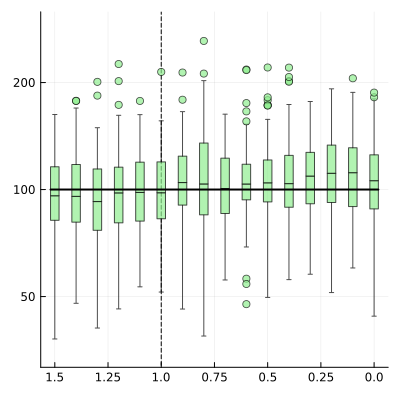

In [33]:
# Reading and plotting the inferred parameters
# Estimation method: heterogeneous-response model, rel. division rate set to zero, known f_on
m = "het_zero_div"
P_inc_fit = plot(size=(400,400))
vline!([11], style=:dash, c=:black, lab="")
for j = 1:2:J
    inferred_para = subset(DataFrame(CSV.File("inferred_parameters/"*p*"/"*m*"_$j.csv")), :AIC => ByRow(a->!isinf(a)))
    boxplot!(P_inc_fit, [j], inferred_para.mutation_rate_on ./ inferred_para.mutation_rate_off, lab="", c=:lightgreen, alpha=0.7)
end
plot!(P_inc_fit, xticks=(collect(1:5:J), range_para[1:5:J]), yscale=:log10, ylim=(10^1.5, 10^2.5), yticks=([50,100,200], [50,100,200]))
plot!(x->mu_on_true/mu_off_true, c=:black, width=2, lab="")
#plot!(xlab="Differential fitness mutants", ylab="Estimated mutation-rate increase")

In [34]:
savefig(P_inc_fit, "figures/Figure_A_3.pdf")

"/Users/lucylansch-justen/Documents/Still evolving/Quantifying-SIM/figures/Figure_A_3.pdf"

### Figure 4: Estimation when response-on cells have a non-zero division rate.

In [9]:
# Reading the (true) input parameters
p = "range_rel-div-on"
true_para = DataFrame(CSV.File("input_parameters/"*p*".csv"))
range_para = collect(true_para.r_start[1]:true_para.r_increment[1]:true_para.r_end[1]) / true_para.divisions_off[1]
J = length(range_para)
mu_off_true = true_para.mutations_off[1]
mu_on_true = true_para.mutations_on[1]
R = true_para.number_fluctuation_assays[1];


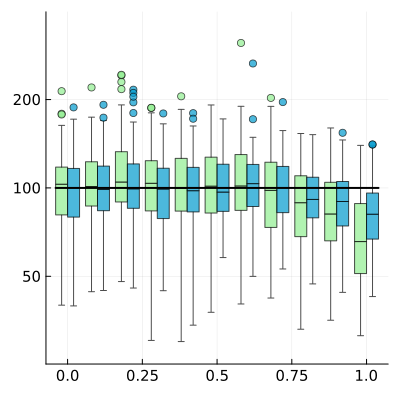

In [8]:
# Reading and plotting the inferred parameters
# Estimation methods: heterogeneous-response model, known f_on and
# (i) setting the rel. division rate to zero
# (ii) inferring the rel. division rate
# Estimated compared to true mutation-rate increase 
m_1 = "het_zero_div"
m_2 = "het_infer_div"
P_inc_div = plot(size=(400,400))
for j = 1:2:J
    inferred_para_1 = subset(DataFrame(CSV.File("inferred_parameters/"*p*"/"*m_1*"_$j.csv")), :AIC => ByRow(a->!isinf(a)))
    inferred_para_2 = subset(DataFrame(CSV.File("inferred_parameters/"*p*"/"*m_2*"_$j.csv")), :AIC => ByRow(a->!isinf(a)))
    boxplot!(P_inc_div, [j-0.4], inferred_para_1.mutation_rate_on ./ inferred_para_1.mutation_rate_off, lab="", c=:lightgreen, alpha=0.7)
    boxplot!(P_inc_div, [j+0.4], inferred_para_2.mutation_rate_on ./ inferred_para_2.mutation_rate_off, lab="", c=:deepskyblue3, alpha=0.7)
end
plot!(P_inc_div, xticks=(collect(1:5:J), range_para[1:5:J]), yscale=:log10, ylim=(10^1.4, 10^2.6), yticks=([50,100,200], [50,100,200]))
plot!(x->mu_on_true/mu_off_true, c=:black, width=2, lab="", tickfontsize=10)
#plot!(xlab="Rel. division rate of response-on cells", ylab="Estimated mutation-rate increase")
#scatter!([0], [1], lab="Set rel. division to 0", c=:lightgreen, alpha=0.7, marker=:square)
#scatter!([0], [1], lab="Infer rel. division", c=:deepskyblue3, alpha=0.7, marker=:square)

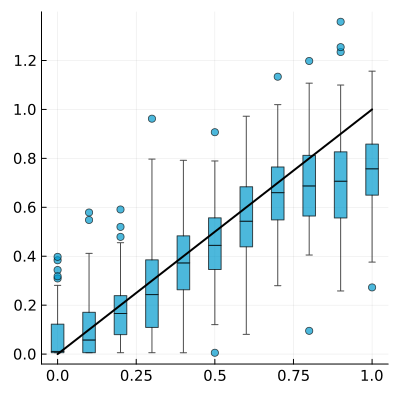

In [9]:
# Reading and plotting the inferred parameters
# Estimation methods: heterogeneous-response model, inferring the rel. division rate, known f_on
# Estimated compared to true rel. division rate of response-on cells
m = "het_infer_div"
P_div = plot(size=(400,400))
for j = 1:2:J
    inferred_para = subset(DataFrame(CSV.File("inferred_parameters/"*p*"/"*m*"_$j.csv")), :AIC => ByRow(a->!isinf(a)))
    boxplot!(P_div, [j], inferred_para.division_rate_on, lab="", c=:deepskyblue3, alpha=0.7, boxwidth=0.4)
end
plot!(P_div, xticks=(collect(1:5:J), range_para[1:5:J]))
plot!(collect(1:J), range_para, lab="", c=:black, width=2, tickfontsize=10)
#plot!(xlab="True rel. division rate", ylab="Estimated rel. division rate")

In [40]:
savefig(P_inc_div, "figures/Figure_4A.pdf")
savefig(P_div, "figures/Figure_4B.pdf")

"/Users/lucylansch-justen/Documents/Still evolving/Quantifying-SIM/figures/Figure_4B.pdf"

#### Appendix Figure: Approximated mutant count distribution depending on the relative division rate of response-on cells.

In [152]:
# Reading the (true) input parameters
p = "range_rel-div-on"
true_para = DataFrame(CSV.File("input_parameters/"*p*".csv"))
range_para = collect(true_para.r_start[1]:true_para.r_increment[1]:true_para.r_end[1]) / true_para.divisions_off[1]
J = length(range_para)
mu_off_true = true_para.mutations_off[1]
mu_on_true = true_para.mutations_on[1]
R = true_para.number_fluctuation_assays[1];

In [164]:
r = 21
mcs_s = DataFrame(CSV.File("output_data/"*p*"/mutant_counts_$r.csv"))
Nf_s, f_on = DataFrame(CSV.File("output_data/"*p*"/population_sizes_$r.csv")).value
mcs_p = DataFrame(CSV.File("output_data/"*p*"/mutant_counts_p.csv"))
Nf_p = DataFrame(CSV.File("output_data/"*p*"/population_sizes_p.csv")).value[1]
mc_s = Vector{Int}(undef, 0)
mc_p = Vector{Int}(undef, 0)
for j = 1:size(mcs_s)[2]
    mc_s = [mc_s; mcs_s[:,j]]
    mc_p = [mc_p; mcs_p[:,R*(r-1)+j]]
end

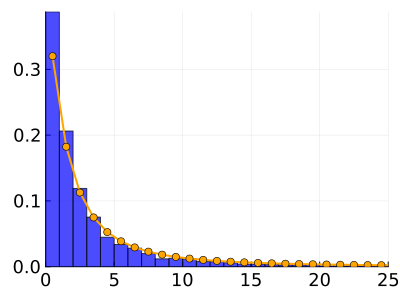

In [165]:
c_max = 25
P_dist = plot(size=(400,300), tickfontsize=12)
histogram!(mc_s[mc_s.<c_max], normalized=true, xlim=(0,c_max), lab="", bins=c_max+1, c=:blue, alpha=0.7)
p_het = P_mutant_count(c_max, mu_off_true, Nf_s, mu_on_true, f_on, rel_div_on=range_para[r]) 
plot!(P_dist, collect(0:c_max).+0.5, p_het, lab="", width=2, c=:orange)
scatter!(collect(0:c_max).+0.5, p_het, lab="", c=:orange)
#scatter!([-1], [0], c=:orange, lab="Approximated mutant count distribution", title="Rel. division = $(range_para[r])")

In [166]:
savefig(P_dist, "figures/Figure_A_0_$r.pdf")

"/Users/s2089131/Documents/Still evolving/Quantifying-SIM/figures/Figure_A_021.pdf"

#### Appendix Figure: Estimation when response-on cells have a (known) non-zero division rate.

In [41]:
# Reading the (true) input parameters
p = "range_rel-div-on"
true_para = DataFrame(CSV.File("input_parameters/"*p*".csv"))
range_para = collect(true_para.r_start[1]:true_para.r_increment[1]:true_para.r_end[1]) / true_para.divisions_off[1]
J = length(range_para)
mu_off_true = true_para.mutations_off[1]
mu_on_true = true_para.mutations_on[1];

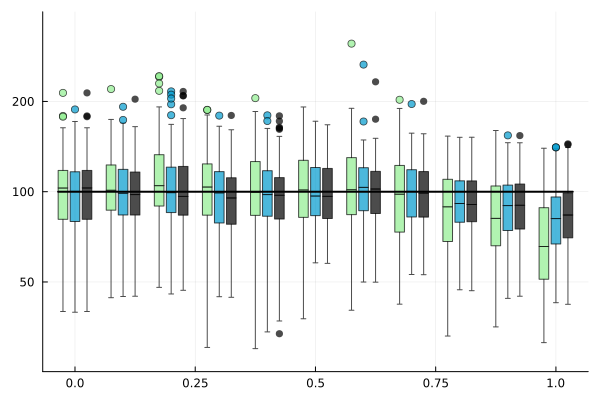

In [43]:
# Reading and plotting the inferred parameters
# Estimation methods: heterogeneous-response model, known f_on and
# (i) setting the rel. division rate to zero
# (ii) inferring the rel. division rate
# (iii) setting the rel. division rate to its true value
# Estimated compared to true mutation-rate increase 
m_1 = "het_zero_div"
m_2 = "het_infer_div"
m_3 = "het_set_div"
P_inc_div_A = plot(size=(600,400))
for j = 1:2:J
    inferred_para_1 = subset(DataFrame(CSV.File("inferred_parameters/"*p*"/"*m_1*"_$j.csv")), :AIC => ByRow(a->!isinf(a)))
    inferred_para_2 = subset(DataFrame(CSV.File("inferred_parameters/"*p*"/"*m_2*"_$j.csv")), :AIC => ByRow(a->!isinf(a)))
    inferred_para_3 = subset(DataFrame(CSV.File("inferred_parameters/"*p*"/"*m_3*"_$j.csv")), :AIC => ByRow(a->!isinf(a)))
    boxplot!(P_inc_div_A, [j-0.5], inferred_para_1.mutation_rate_on ./ inferred_para_1.mutation_rate_off, lab="", c=:lightgreen, alpha=0.7, bar_width=0.4)
    boxplot!(P_inc_div_A, [j], inferred_para_2.mutation_rate_on ./ inferred_para_2.mutation_rate_off, lab="", c=:deepskyblue3, alpha=0.7, bar_width=0.4)
    boxplot!(P_inc_div_A, [j+0.5], inferred_para_3.mutation_rate_on ./ inferred_para_3.mutation_rate_off, lab="", c=:black, alpha=0.7, bar_width=0.4)
end
plot!(P_inc_div_A, xticks=(collect(1:5:J), range_para[1:5:J]), yscale=:log10, ylim=(10^1.4, 10^2.6), yticks=([50,100,200], [50,100,200]))
plot!(x->mu_on_true/mu_off_true, c=:black, width=2, lab="")
#plot!(xlab="Rel. division rate of response-on cells", ylab="Estimated mutation-rate increase")
#scatter!([0], [1], lab="Set rel. division to 0", c=:lightgreen, alpha=0.7, marker=:square)
#scatter!([0], [1], lab="Infer rel. division", c=:deepskyblue3, alpha=0.7, marker=:square)
#scatter!([0], [1], lab="Set rel. division to true value", c=:black, alpha=0.7, marker=:square)

In [44]:
savefig(P_inc_div_A, "figures/Figure_A_4.pdf")

"/Users/lucylansch-justen/Documents/Still evolving/Quantifying-SIM/figures/Figure_A_4.pdf"

### Figure 5: Model selection heterogeneous-response model - homogeneous-response model without/with differential fitness of mutants

In [81]:
# Reading the (true) input parameters
p = "range_rel-div-on"
true_para = DataFrame(CSV.File("input_parameters/"*p*".csv"))
range_para = collect(true_para.r_start[1]:true_para.r_increment[1]:true_para.r_end[1]) / true_para.divisions_off[1]
J = length(range_para)
mu_off_true = true_para.mutations_off[1]
mu_on_true = true_para.mutations_on[1]
mu_mean_true = Vector{Float64}(undef, J)
for j = 1:J
    f_on = DataFrame(CSV.File("output_data/"*p*"/population_sizes_$j.csv")).value[2]
    mu_mean_true[j] = f_on * mu_on_true + (1-f_on)*mu_off_true
end
R = true_para.number_fluctuation_assays[1];
     

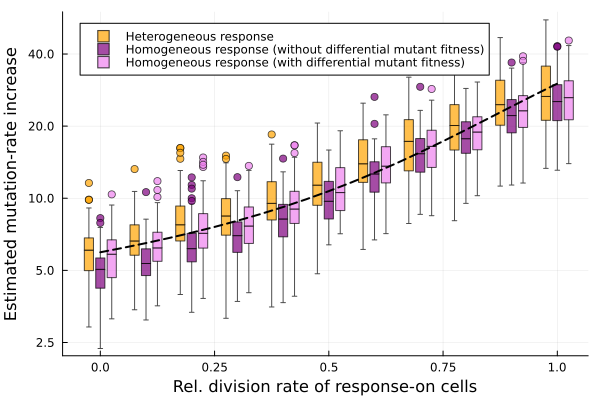

In [82]:
# Reading and plotting the inferred parameters
# Estimation methods:
# Heterogeneous-response model with rel. division rate set to zero (unknown f_on)
# (i) Homogeneous-response model with fitness of mutants set to one
# (ii) Homogeneous-response model with fitness of mutants permissive/stressful inferred
# Estimated population-wide mutation-rate increase 
m_het = "het_zero_div_unknown_fraction"
m_1 = "hom_no_fit"
m_2 = "hom_infer_fit"
P_mean = plot(size=(600,400))
for j = 1:2:J
    inferred_para_het = subset(DataFrame(CSV.File("inferred_parameters/"*p*"/"*m_het*"_$j.csv")), :AIC => ByRow(a->!isinf(a)))
    inferred_para_1 = subset(DataFrame(CSV.File("inferred_parameters/"*p*"/"*m_1*"_$j.csv")), :AIC => ByRow(a->!isinf(a)))
    inferred_para_2 = subset(DataFrame(CSV.File("inferred_parameters/"*p*"/"*m_2*"_$j.csv")), :AIC => ByRow(a->!isinf(a)))
    boxplot!(P_mean, [j-0.5], (inferred_para_het.mutation_rate_on .* inferred_para_het.fraction_on .+ inferred_para_het.mutation_rate_off .* (1 .- inferred_para_het.fraction_on)) ./ inferred_para_het.mutation_rate_off, lab="", c=:orange, alpha=0.7, bar_width=0.4)
    boxplot!(P_mean, [j], inferred_para_1.mutation_rate_s ./ inferred_para_1.mutation_rate_p, lab="", c=:purple, alpha=0.7, bar_width=0.4)
    boxplot!(P_mean, [j+0.5], inferred_para_2.mutation_rate_s ./ inferred_para_2.mutation_rate_p, lab="", c=:violet, alpha=0.7, bar_width=0.4)
end
plot!(P_mean, xticks=(collect(1:5:J), range_para[1:5:J]), yscale=:log10, ylim=(2.2, 60), yticks=([2.5,5,10,20,40], [2.5,5,10,20,40]))
plot!(collect(1:J), mu_mean_true/mu_off_true, c=:black, width=2, lab="", style=:dash)
plot!(xlab="Rel. division rate of response-on cells", ylab="Estimated mutation-rate increase")
scatter!([0], [1], lab="Heterogeneous response", c=:orange, alpha=0.7, marker=:square)
scatter!([0], [1], lab="Homogeneous response (without differential mutant fitness)", c=:purple, alpha=0.7, marker=:square)
scatter!([0], [1], lab="Homogeneous response (with differential mutant fitness)", c=:violet, alpha=0.7, marker=:square)

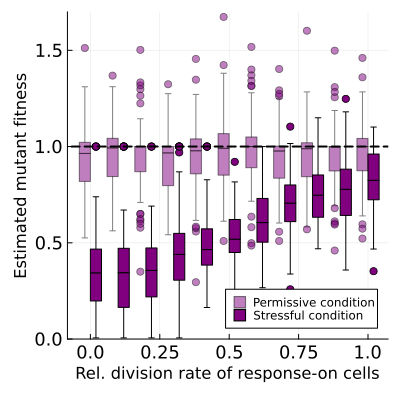

In [83]:
# Reading and plotting the inferred parameters
# Estimation method: Homogeneous-response model with fitness of mutants permissive/stressful inferred
# Estimated mutant fitness
m = "hom_infer_fit"
P_rho = plot(size=(400,400))
for j = 1:2:J
    inferred_para = subset(DataFrame(CSV.File("inferred_parameters/"*p*"/"*m*"_$j.csv")), :AIC => ByRow(a->!isinf(a)))
    boxplot!(P_rho, [j-0.4], inferred_para.fitness_mutants_p, lab="", c=:purple, alpha=0.5)
    boxplot!(P_rho, [j+0.4], inferred_para.fitness_mutants_s, lab="", c=:purple)
end
plot!(P_rho, xticks=(collect(1:5:J), range_para[1:5:J]), ylim=(0,1.7))
hline!([1], c=:black, width=2, lab="", tickfontsize=12, style=:dash)
plot!(xlab="Rel. division rate of response-on cells", ylab="Estimated mutant fitness")
scatter!([0], [-1], lab="Permissive condition", c=:purple, alpha=0.5, marker=:square)
scatter!([0], [-1], lab="Stressful condition", c=:purple, marker=:square)

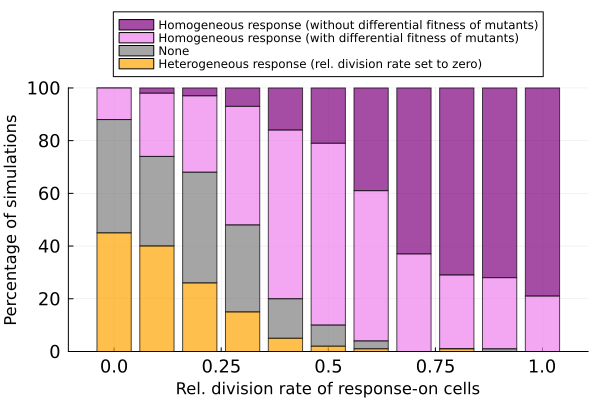

In [84]:
# Reading AIC values and selecting a model
# Heterogeneous-response model with rel. division rate set to zero (unknown f_on)
# (i) Homogeneous-response model with fitness of mutants set to one
# (ii) Homogeneous-response model with fitness of mutants permissive/stressful inferred
m_het = "het_zero_div_unknown_fraction"
m_1 = "hom_no_fit"
m_2 = "hom_infer_fit"
select_het = Vector{Int}(undef, J)
select_hom_1 = Vector{Int}(undef, J)
select_hom_2 = Vector{Int}(undef, J)
select_none = Vector{Int}(undef, J)
for j = 1:2:J
    AIC_het = DataFrame(CSV.File("inferred_parameters/"*p*"/"*m_het*"_$j.csv")).AIC
    AIC_1 = DataFrame(CSV.File("inferred_parameters/"*p*"/"*m_1*"_$j.csv")).AIC
    AIC_2 = DataFrame(CSV.File("inferred_parameters/"*p*"/"*m_2*"_$j.csv")).AIC
    AIC_12 = AIC_1 .- AIC_2
    AIC_hom = minimum([AIC_1 AIC_2], dims=2)
    AIC_diff = AIC_het .- AIC_hom
    select_het[j] = sum(AIC_diff .< -2)
    select_hom_1[j] = sum( (AIC_diff .> 2) .* (AIC_12 .< 0))
    select_hom_2[j] = sum( (AIC_diff .> 2) .* (AIC_12 .> 0))
    select_none[j] = R - select_het[j] - select_hom_1[j] - select_hom_2[j]
end
P_AIC = groupedbar([select_hom_1[1:2:J] select_hom_2[1:2:J] select_none[1:2:J] select_het[1:2:J]], bar_position=:stack, c=[:purple :violet :grey :orange], alpha=0.7, label=["Homogeneous response (without differential fitness of mutants)" "Homogeneous response (with differential fitness of mutants)" "None" "Heterogeneous response (rel. division rate set to zero)"])
plot!(size=(600,400), xticks=(collect(1:2.5:J/2+1), range_para[1:5:J]), tickfontsize=12)
plot!(xlab="Rel. division rate of response-on cells", ylab="Percentage of simulations", legend=:outertop)

In [85]:
savefig(P_mean, "figures/Figure_5A.pdf")
savefig(P_rho, "figures/Figure_5B.pdf")
savefig(P_AIC, "figures/Figure_5C.pdf")

"/Users/s2089131/Documents/Still evolving/Quantifying-SIM/figures/Figure_5C.pdf"

### Appendix: Model selection heterogeneous-response model - homogeneous-response model with jointly inferred differential fitness of mutants

In [86]:
# Reading the (true) input parameters
p = "range_rel-div-on"
true_para = DataFrame(CSV.File("input_parameters/"*p*".csv"))
range_para = collect(true_para.r_start[1]:true_para.r_increment[1]:true_para.r_end[1]) ./ true_para.divisions_off
J = length(range_para)
mu_off_true = true_para.mutations_off[1]
mu_on_true = true_para.mutations_on[1]
mu_mean_true = Vector{Float64}(undef, J)
for j = 1:J
    f_on = DataFrame(CSV.File("output_data/"*p*"/population_sizes_$j.csv")).value[2]
    mu_mean_true[j] = f_on * mu_on_true + (1-f_on)*mu_off_true
end
R = true_para.number_fluctuation_assays[1];
     

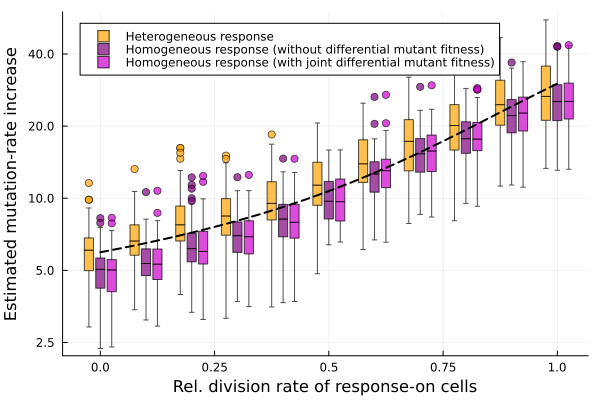

In [87]:
# Reading and plotting the inferred parameters
# Estimation methods:
# Heterogeneous-response model with rel. division rate set to zero (unknown f_on)
# (i) Homogeneous-response model with fitness of mutants set to one
# (ii) Homogeneous-response model with jointly inferred fitness of mutants
# Estimated population-wide mutation-rate increase 
m_het = "het_zero_div_unknown_fraction"
m_1 = "hom_no_fit"
m_2 = "hom_joint_fit"
P_mean_A = plot(size=(600,400))
for j = 1:2:J
    inferred_para_het = subset(DataFrame(CSV.File("inferred_parameters/"*p*"/"*m_het*"_$j.csv")), :AIC => ByRow(a->!isinf(a)))
    inferred_para_1 = subset(DataFrame(CSV.File("inferred_parameters/"*p*"/"*m_1*"_$j.csv")), :AIC => ByRow(a->!isinf(a)))
    inferred_para_2 = subset(DataFrame(CSV.File("inferred_parameters/"*p*"/"*m_2*"_$j.csv")), :AIC => ByRow(a->!isinf(a)))
    boxplot!(P_mean_A, [j-0.5], (inferred_para_het.mutation_rate_on .* inferred_para_het.fraction_on .+ inferred_para_het.mutation_rate_off .* (1 .- inferred_para_het.fraction_on)) ./ inferred_para_het.mutation_rate_off, lab="", c=:orange, alpha=0.7, bar_width=0.4)
    boxplot!(P_mean_A, [j], inferred_para_1.mutation_rate_s ./ inferred_para_1.mutation_rate_p, lab="", c=:purple, alpha=0.7, bar_width=0.4)
    boxplot!(P_mean_A, [j+0.5], inferred_para_2.mutation_rate_s ./ inferred_para_2.mutation_rate_p, lab="", c=:magenta3, alpha=0.7, bar_width=0.4)
end
plot!(P_mean_A, xticks=(collect(1:5:J), range_para[1:5:J]), yscale=:log10, ylim=(2.2, 60), yticks=([2.5,5,10,20,40], [2.5,5,10,20,40]))
plot!(collect(1:J), mu_mean_true/mu_off_true, c=:black, width=2, lab="", style=:dash)
plot!(xlab="Rel. division rate of response-on cells", ylab="Estimated mutation-rate increase")
scatter!([0], [1], lab="Heterogeneous response", c=:orange, alpha=0.7, marker=:square)
scatter!([0], [1], lab="Homogeneous response (without differential mutant fitness)", c=:purple, alpha=0.7, marker=:square)
scatter!([0], [1], lab="Homogeneous response (with joint differential mutant fitness)", c=:magenta3, alpha=0.7, marker=:square)

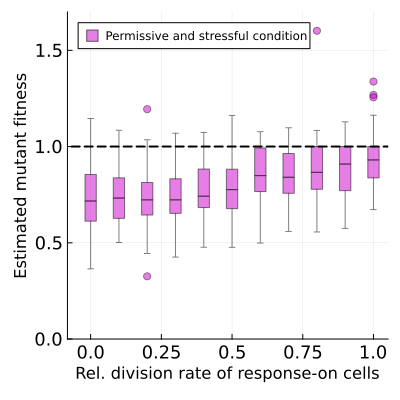

In [90]:
# Reading and plotting the inferred parameters
# Estimation method: Homogeneous-response model with jointly inferred fitness of mutants 
# Estimated mutant fitness
m = "hom_joint_fit"
P_rho_A = plot(size=(400,400))
for j = 1:2:J
    inferred_para = subset(DataFrame(CSV.File("inferred_parameters/"*p*"/"*m*"_$j.csv")), :AIC => ByRow(a->!isinf(a)))
    boxplot!(P_rho_A, [j], inferred_para.fitness_mutants_s, lab="", c=:magenta3, alpha=0.5)
end
plot!(P_rho_A, xticks=(collect(1:5:J), range_para[1:5:J]), ylim=(0,1.7))
hline!([1], c=:black, width=2, lab="", tickfontsize=12, style=:dash)
plot!(xlab="Rel. division rate of response-on cells", ylab="Estimated mutant fitness")
scatter!([0], [-1], lab="Permissive and stressful condition", c=:magenta3, alpha=0.5, marker=:square)


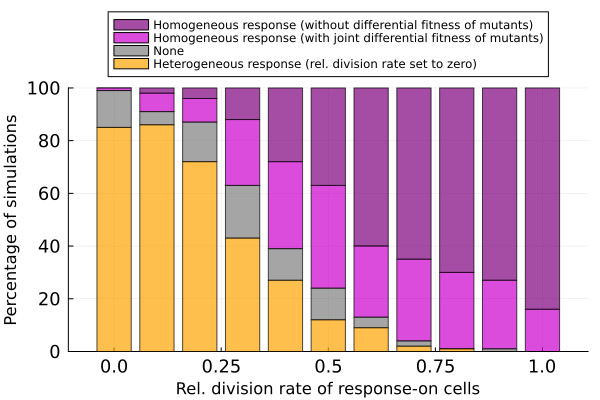

In [92]:
# Reading AIC values and selecting a model
# Heterogeneous-response model with rel. division rate set to zero (unknown f_on)
# (i) Homogeneous-response model with fitness of mutants set to one
# (ii) Homogeneous-response model with jointly inferred fitness of mutants
m_het = "het_zero_div_unknown_fraction"
m_1 = "hom_no_fit"
m_2 = "hom_joint_fit"
select_het = Vector{Int}(undef, J)
select_hom_1 = Vector{Int}(undef, J)
select_hom_2 = Vector{Int}(undef, J)
select_none = Vector{Int}(undef, J)
for j = 1:2:J
    AIC_het = DataFrame(CSV.File("inferred_parameters/"*p*"/"*m_het*"_$j.csv")).AIC
    AIC_1 = DataFrame(CSV.File("inferred_parameters/"*p*"/"*m_1*"_$j.csv")).AIC
    AIC_2 = DataFrame(CSV.File("inferred_parameters/"*p*"/"*m_2*"_$j.csv")).AIC
    AIC_12 = AIC_1 .- AIC_2
    AIC_hom = minimum([AIC_1 AIC_2], dims=2)
    AIC_diff = AIC_het .- AIC_hom
    select_het[j] = sum(AIC_diff .< -2)
    select_hom_1[j] = sum( (AIC_diff .> 2) .* (AIC_12 .< 0))
    select_hom_2[j] = sum( (AIC_diff .> 2) .* (AIC_12 .> 0))
    select_none[j] = R - select_het[j] - select_hom_1[j] - select_hom_2[j]
end
P_AIC_A = groupedbar([select_hom_1[1:2:J] select_hom_2[1:2:J] select_none[1:2:J] select_het[1:2:J]], bar_position=:stack, c=[:purple :magenta3 :grey :orange], alpha=0.7, label=["Homogeneous response (without differential fitness of mutants)" "Homogeneous response (with joint differential fitness of mutants)" "None" "Heterogeneous response (rel. division rate set to zero)"])
plot!(size=(600,400), xticks=(collect(1:2.5:J/2+1), range_para[1:5:J]), tickfontsize=12)
plot!(xlab="Rel. division rate of response-on cells", ylab="Percentage of simulations", legend=:outertop)

In [93]:
savefig(P_mean_A, "figures/Figure_A_5A.pdf")
savefig(P_rho_A, "figures/Figure_A_5B.pdf")
savefig(P_AIC_A, "figures/Figure_A_5C.pdf")

"/Users/s2089131/Documents/Still evolving/Quantifying-SIM/figures/Figure_A_5C.pdf"

### Appendix Figure: Testing the validity of the assumption that the response-on subpopulation can be treated deterministically

In [78]:
# Reading the (true) input parameters
p = "range_switching"
p2 = "range_rel-div-on"
true_para_1 = DataFrame(CSV.File("input_parameters/"*p*".csv"))
true_para_2 = DataFrame(CSV.File("input_parameters/"*p2*".csv"))
range_para_1 = 10 .^ collect(true_para_1.r_start[1]:true_para_1.r_increment[1]:true_para_1.r_end[1]) 
range_para_2 = collect(true_para_2.r_start[1]:true_para_2.r_increment[1]:true_para_2.r_end[1])
J1 = length(range_para_1)
J2 = length(range_para_2)
f0_on = [0., 0.01, 1.]
Nf = 10^9
N0 = true_para_1.initial_population_size[1]
div_off = true_para_1.divisions_off[1]
mu_off = true_para_1.mutations_off[1]
mu_on = true_para_1.mutations_on[1];

In [87]:
# Reading and plotting the output data
# Comparing with determinist equation for the size of the response-on subpopulation
include("population_dynamics.jl")
# Relative error and coefficient of variation across the simulations
RE_alpha_div_t1 = Matrix{Float64}(undef, (J2, J1))
CV_alpha_div_t1 = Matrix{Float64}(undef, (J2, J1))
RE_alpha_div_tf = Matrix{Float64}(undef, (J2, J1))
CV_alpha_div_tf = Matrix{Float64}(undef, (J2, J1))
f = 1
for j2 = 1:J2
    p_folder = "/rel-div_$j2"
    for j1 = 1:J1
        f0_on[end] = range_para_1[j1]/div_off
        N_on_t1 = DataFrame(CSV.File("output_data/"*p*p_folder*"/popsize_nm_on_t1_$j1.csv"))
        N_on_tf = DataFrame(CSV.File("output_data/"*p*p_folder*"/popsize_nm_on_tf_$j1.csv"))
        tf = t_final(N0, div_off-range_para_1[j1], Nf) 
        t1 = t_first_m(N0, div_off-range_para_1[j1], mu_off*(1-f0_on[f])+mu_on*f0_on[f])
        RE_alpha_div_t1[j2, j1] = (median(N_on_t1[:,f]) - pop_size(t1, N0*(1-f0_on[f]), div_off-range_para_1[j1], range_para_1[j1], N0*f0_on[f], range_para_2[j2])) / pop_size(t1, N0*(1-f0_on[f]), div_off-range_para_1[j1], range_para_1[j1], N0*f0_on[f], range_para_2[j2])
        RE_alpha_div_tf[j2, j1] = (median(N_on_tf[:,f]) - pop_size(tf, N0*(1-f0_on[f]), div_off-range_para_1[j1], range_para_1[j1], N0*f0_on[f], range_para_2[j2])) / pop_size(tf, N0*(1-f0_on[f]), div_off-range_para_1[j1], range_para_1[j1], N0*f0_on[f], range_para_2[j2])
        CV_alpha_div_t1[j2, j1] = std(N_on_t1[:,f]) / mean(N_on_t1[:,f])
        CV_alpha_div_tf[j2, j1] = std(N_on_tf[:,f]) / mean(N_on_tf[:,f])
    end
end

Initial fraction = 0.1

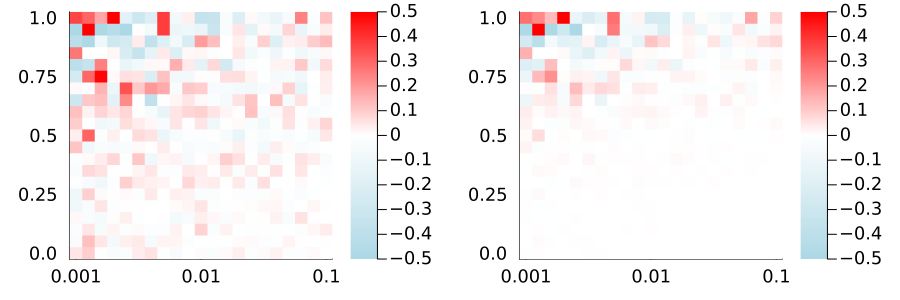

In [88]:
c_max = 0.5
c_min = -0.5
P_RE_t1 = plot(size=(400,300), rightmargin=5mm)
heatmap!(100 .*RE_alpha_div_t1, c=cgrad([:lightblue,:white,:red], [0,-c_min/(c_max-c_min),1]), clim=(c_min, c_max))
plot!(xticks=(collect(1:10:J1), range_para_1[1:10:J1]/div_off), yticks=(collect(1:5:J2), range_para_2[1:5:J2]/div_off), tickfontsize=12)
#plot!(title="Early time point", colorbar_title="Relative error in % (median)", xlab="Relative switching rate", ylab="Relative division rate", rightmargin=15mm)
P_RE_tf = plot(size=(400,300), rightmargin=5mm)
heatmap!(100 .*RE_alpha_div_tf, c=cgrad([:lightblue,:white,:red], [0,-c_min/(c_max-c_min),1]), clim=(c_min, c_max))
plot!(xticks=(collect(1:10:J1), range_para_1[1:10:J1]/div_off), yticks=(collect(1:5:J2), range_para_2[1:5:J2]/div_off), tickfontsize=12)
#plot!(title="Late time point", colorbar_title="Relative error in % (median)", xlab="Relative switching rate", ylab="Relative division rate", rightmargin=15mm)
print("Initial fraction = $(f0_on[f])")
plot(P_RE_t1, P_RE_tf,size=(900,300), bottommargin=5mm, leftmargin=3mm)

Initial fraction = 0.1

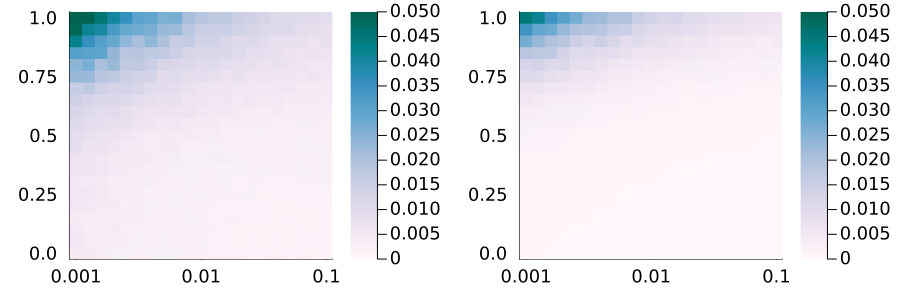

In [89]:
c_max = 0.05
P_CV_t1 = plot(size=(400,300), rightmargin=5mm)
heatmap!(CV_alpha_div_t1, fill=true, levels=8, c=:PuBuGn_8, clim=(0, c_max))
plot!(xticks=(collect(1:10:J1), range_para_1[1:10:J1]/div_off), yticks=(collect(1:5:J2), range_para_2[1:5:J2]/div_off), tickfontsize=12)
#plot!(title="Early time point", colorbar_title="Coefficient of variation", xlab="Relative switching rate", ylab="Relative division rate")
P_CV_tf = plot(size=(400,300), rightmargin=5mm)
heatmap!(CV_alpha_div_tf, fill=true, levels=8, c=:PuBuGn_8, clim=(0, c_max))
plot!(xticks=(collect(1:10:J1), range_para_1[1:10:J1]/div_off), yticks=(collect(1:5:J2), range_para_2[1:5:J2]/div_off), tickfontsize=12)
#plot!(title="Late time point", colorbar_title="Coefficient of variation", xlab="Relative switching rate", ylab="Relative division rate")
print("Initial fraction = $(f0_on[f])")
plot(P_CV_t1, P_CV_tf,size=(900,300), bottommargin=5mm, leftmargin=3mm)

In [90]:
savefig(P_RE_t1, "figures/Figure_A_6A$f.png")
savefig(P_RE_tf, "figures/Figure_A_6B$f.png")
savefig(P_CV_t1, "figures/Figure_A_6C$f.png")
savefig(P_CV_tf, "figures/Figure_A_6D$f.png")

"/Users/s2089131/Documents/Still evolving/Quantifying-SIM/figures/Figure_A_6D3.png"